In [351]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import StandardScaler
import optuna
from torch.utils.data import DataLoader, TensorDataset 
import torchmetrics


import warnings
warnings.filterwarnings("ignore")

In [352]:
DATA_PATH = "../data/PDB_Load_History.csv"

In [353]:
df =  pd.read_csv(DATA_PATH, parse_dates=['date'])
df.head()

,date,year,month,day,weekday,hour,demand,temperature
0,2003-03-01,2003,3,1,7,1,12863.0,29
1,2003-03-01,2003,3,1,7,2,12389.0,28
2,2003-03-01,2003,3,1,7,3,12155.0,29
3,2003-03-01,2003,3,1,7,4,12072.0,27
4,2003-03-01,2003,3,1,7,5,12160.0,29


In [354]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103776 entries, 0 to 103775
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   date         103776 non-null  datetime64[ns]
 1   year         103776 non-null  int64         
 2   month        103776 non-null  int64         
 3   day          103776 non-null  int64         
 4   weekday      103776 non-null  int64         
 5   hour         103776 non-null  int64         
 6   demand       103776 non-null  float64       
 7   temperature  103776 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(6)
memory usage: 6.3 MB


There are neither **Missing values** or **Duplicate data points**

In [355]:
print(df['date'].min())
print(df['date'].max())

2003-03-01 00:00:00
2014-12-31 00:00:00


Data was collected from 1st of March, 2003 to 31st of December 2014, spanning about 11 years

## Check if date frequency is regular

In [356]:
df['date'].diff().value_counts()

date
0 days    99452
1 days     4323
Name: count, dtype: int64

Date freq is **not constant** throughout the data

### Resample to every 24 hours to make it even

In [357]:
df = df.resample('d', on = 'date').mean().reset_index()
df.head()


,date,year,month,day,weekday,hour,demand,temperature
0,2003-03-01,2003.0,3.0,1.0,7.0,12.5,14216.875,32.083333
1,2003-03-02,2003.0,3.0,2.0,1.0,12.5,13851.625,34.458333
2,2003-03-03,2003.0,3.0,3.0,2.0,12.5,16348.875,14.958333
3,2003-03-04,2003.0,3.0,4.0,3.0,12.5,16575.500,18.791667
4,2003-03-05,2003.0,3.0,5.0,4.0,12.5,15391.875,36.458333


## Visualize

In [358]:
df[['demand']].describe().T

,count,mean,std,min,25%,50%,75%,max
demand,4324.0,14674.947493,1746.835984,10265.541667,13482.760417,14402.770833,15626.552083,22866.208333


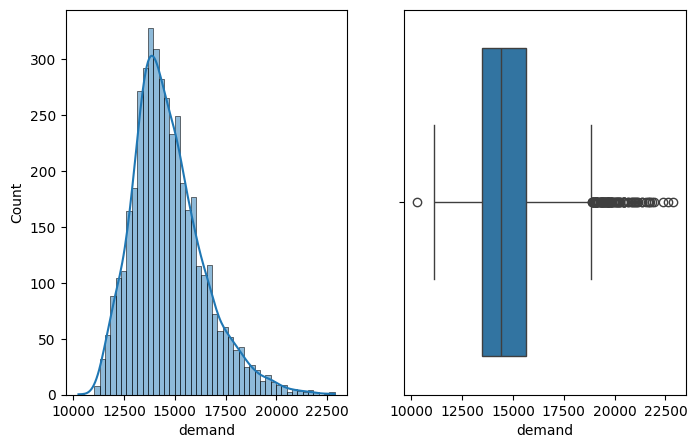

In [359]:
fig, ax = plt.subplots(1, 2, figsize = (8, 5))
sns.histplot(data = df, x = 'demand', kde = True, ax = ax[0])
sns.boxplot(data = df, x = 'demand', ax = ax[1]);

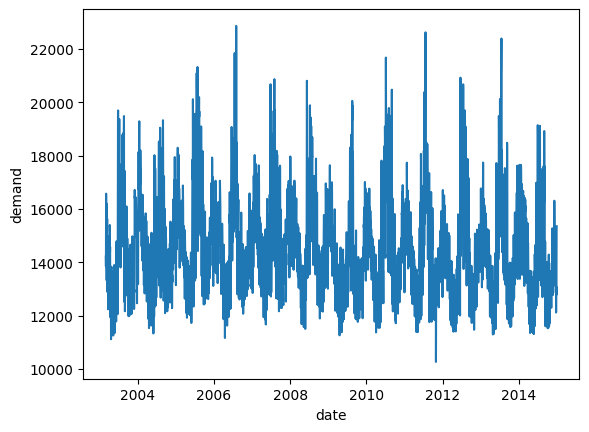

In [360]:
sns.lineplot(data = df, x = 'date', y = 'demand');

## Split into Train and Test set

In [361]:
split_idx = int(len(df) * 0.8)
train_data = df[: split_idx]
test_data = df[split_idx: ]

In [362]:
train_data.shape, test_data.shape

((3459, 8), (865, 8))

## Chehcking Sequence Length for Model

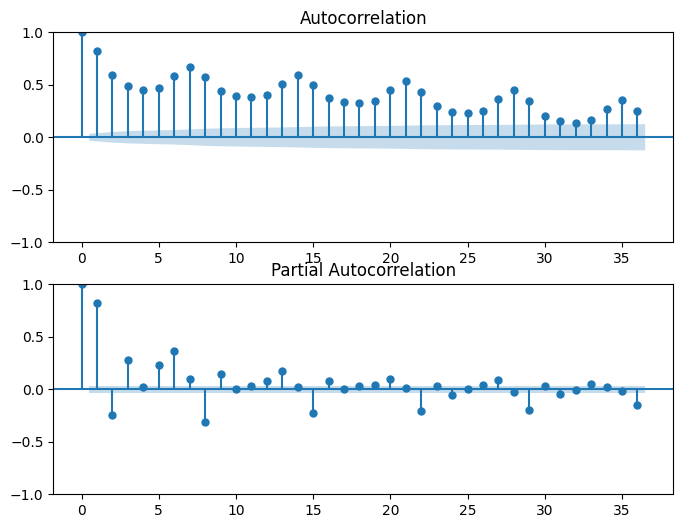

In [363]:
fig, ax = plt.subplots(2, 1, figsize = (8, 6))
plot_acf(train_data['demand'], ax = ax[0])
plot_pacf(train_data['demand'], ax = ax[1]);

## Prepare Data for Model

In [364]:
# 1. drop target
train_data = train_data.drop(columns = ['date'], axis = 1)
test_data = test_data.drop(columns = ['date'], axis = 1)

In [365]:
train_data.head()

,year,month,day,weekday,hour,demand,temperature
0,2003.0,3.0,1.0,7.0,12.5,14216.875,32.083333
1,2003.0,3.0,2.0,1.0,12.5,13851.625,34.458333
2,2003.0,3.0,3.0,2.0,12.5,16348.875,14.958333
3,2003.0,3.0,4.0,3.0,12.5,16575.500,18.791667
4,2003.0,3.0,5.0,4.0,12.5,15391.875,36.458333


In [366]:
# 2. scale features
def preprocess(train: pd.DataFrame, test: pd.DataFrame):
    scaler  = StandardScaler()
    train = scaler.fit_transform(train)
    test = scaler.transform(test)

    return (train, test)

In [367]:
train_data, test_data = preprocess(train_data, test_data)

In [368]:
#  3. Create Sequence/Window size
def create_sequence(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i: i + seq_length]
        y = data[i + seq_length, 5] #target is on index 5
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [369]:
SEQ_LENGTH = 8
X_train, y_train = create_sequence(train_data, SEQ_LENGTH)
X_test, y_test = create_sequence(test_data, SEQ_LENGTH)

In [370]:
dataset_train = TensorDataset(torch.tensor(X_train).float(), torch.tensor(y_train).float())
dataset_test = TensorDataset(torch.tensor(X_train).float(), torch.tensor(y_train).float())

In [371]:
dataloader_train = DataLoader(dataset_train, shuffle= False, batch_size = 32)
dataloader_test = DataLoader(dataset_test, shuffle= False, batch_size = 32)

## Build GRU Architecture

In [372]:
print(torch.backends.mps.is_available())

True


In [373]:
print(torch.backends.mps.is_built())

True


In [374]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

Using device: mps


In [375]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.gru = nn.GRU(
            input_size= 7, hidden_size= 64, num_layers=2, batch_first= True
        )
        self.fc = nn.Linear(64, 1)
    def forward(self, x):
        h0 = torch.zeros(2, x.size(0), 64).to(device)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])

        return out

In [376]:
net = Net()
net = net.to(device)

In [377]:
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.001)

In [378]:
for seq, label in dataloader_train:
    print(seq.shape)
   

torch.Size([32, 8, 7])
torch.Size([32, 8, 7])
torch.Size([32, 8, 7])
torch.Size([32, 8, 7])
torch.Size([32, 8, 7])
torch.Size([32, 8, 7])
torch.Size([32, 8, 7])
torch.Size([32, 8, 7])
torch.Size([32, 8, 7])
torch.Size([32, 8, 7])
torch.Size([32, 8, 7])
torch.Size([32, 8, 7])
torch.Size([32, 8, 7])
torch.Size([32, 8, 7])
torch.Size([32, 8, 7])
torch.Size([32, 8, 7])
torch.Size([32, 8, 7])
torch.Size([32, 8, 7])
torch.Size([32, 8, 7])
torch.Size([32, 8, 7])
torch.Size([32, 8, 7])
torch.Size([32, 8, 7])
torch.Size([32, 8, 7])
torch.Size([32, 8, 7])
torch.Size([32, 8, 7])
torch.Size([32, 8, 7])
torch.Size([32, 8, 7])
torch.Size([32, 8, 7])
torch.Size([32, 8, 7])
torch.Size([32, 8, 7])
torch.Size([32, 8, 7])
torch.Size([32, 8, 7])
torch.Size([32, 8, 7])
torch.Size([32, 8, 7])
torch.Size([32, 8, 7])
torch.Size([32, 8, 7])
torch.Size([32, 8, 7])
torch.Size([32, 8, 7])
torch.Size([32, 8, 7])
torch.Size([32, 8, 7])
torch.Size([32, 8, 7])
torch.Size([32, 8, 7])
torch.Size([32, 8, 7])
torch.Size(

In [379]:
for epoch in range(30):
    loop = tqdm(dataloader_train, leave = True)

    train_loss = 0.0
    for seq, label in loop:
        optimizer.zero_grad()
        seq = seq.to(device)
        label = label.to(device)
        output = net(seq)
        loss = criterion(output, label)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        loop.set_description(f"Epoch [{epoch+1}/{30}]")
        loop.set_postfix(train_loss = loss.item())

    eval_loss = 0.0
    net.eval()
    with torch.no_grad():
        for seq, label in dataloader_test:
            seq = seq.to(device)
            label = label.to(device)
            output = net(seq)
            loss = criterion(output, label)
            eval_loss += loss.item()

            loop.set_description(f"Epoch [{epoch+1}/{30}]")
            loop.set_postfix(train_loss = loss/len(dataloader_train),
                             eval_loss = eval_loss/len(dataloader_test))

    net.train()



Epoch [30/30]: 100%|██████████| 108/108 [00:01<00:00, 71.88it/s, train_loss=0.63] 


In [380]:
mse = torchmetrics.MeanSquaredError().to(device)
net.eval()
with torch.no_grad():
    for seq, label in dataloader_test:
        seq = seq.to(device)
        label = label.to(device)
        output = net(seq).squeeze()
        output = output.to(device)
        mse.update(output, label)
    print("Test MSE:", mse.compute().item())

Test MSE: 0.4813128411769867
